In [1]:
import kagglehub
path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")

Using Colab cache for faster access to the 'mushrooms-classification-common-genuss-images' dataset.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.cuda
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

torch.manual_seed(42)
print(path)


Using device: cuda
/kaggle/input/mushrooms-classification-common-genuss-images


In [3]:
if not path.endswith('Mushrooms'):
    path = os.path.join(path, 'Mushrooms')
print(path)

transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=path, transform=transforms_train)
test_dataset = ImageFolder(root=path, transform=transforms_test)

print(train_dataset.classes)
print(f"Total number of images in the dataset: {len(train_dataset)}")


/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms
['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']
Total number of images in the dataset: 6714


torch.Size([3, 224, 224])


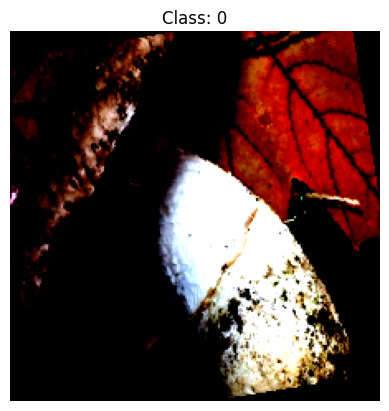

In [4]:
image, label = train_dataset[100]
print(image.shape)
plt.imshow(image.permute(1, 2, 0))  #for matplotlib (C, H, W) -> (H, W, C)
plt.title(f"Class: {label}")
plt.axis('off')
plt.show()

In [5]:
import PIL.Image
from PIL import ImageFile
PIL.Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_indices, test_indices = train_test_split(range(len(train_dataset)), test_size=0.2,
    random_state=42, stratify=[train_dataset[i][1] for i in range(len(train_dataset))])

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
test_subset = torch.utils.data.Subset(test_dataset, test_indices)


In [6]:
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_dataloader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

for batch_idx, (data, target) in enumerate(train_dataloader):
     print(f"Batch {batch_idx}: data shape {data.shape}, target shape {target.shape}")
     break

print(f"Train dataset size: {len(train_subset)}")
print(f"Test dataset size: {len(test_subset)}")
print(f"Number of batches per epoch: {len(train_dataloader)}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch 0: data shape torch.Size([64, 3, 224, 224]), target shape torch.Size([64])
Train dataset size: 5371
Test dataset size: 1343
Number of batches per epoch: 84


In [7]:
def build_alexnet():
    def init_weights(m):
        if type(m)==torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m)==torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)

    net=torch.nn.Sequential(
        nn.Conv2d(3,96, kernel_size=11, stride=4), nn.BatchNorm2d(96),
        nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.BatchNorm2d(256),
        nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(inplace=True),
        nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.AdaptiveAvgPool2d((6, 6)),
        nn.Flatten(),
        nn.Linear(256 * 6 * 6, 4096), nn.BatchNorm1d(4096), torch.nn.ReLU(inplace=True), torch.nn.Dropout(p=0.7),
        torch.nn.Linear(4096,4096), nn.BatchNorm1d(4096), torch.nn.ReLU(inplace=True), torch.nn.Dropout(p=0.7),
        torch.nn.Linear(4096, 10),
    )
    net.apply(init_weights)
    return net

In [8]:
alexnet=build_alexnet()
print(alexnet)

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15):

In [9]:
def train(net, train_loader, device, num_epochs, learning_rate):
    net=net.to(device)
    net.train()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    for epoch in range(num_epochs):
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
          running_loss = 0.0
          correct = 0
          total = 0
          for batch_num, (inputs, labels) in enumerate(train_loader):
               inputs = inputs.to(device)
               labels = labels.to(device)
              #inputs = inputs.permute(0, 3, 1, 2).to(device) if order is not correct

               optimizer.zero_grad()
               # Forward pass
               outputs = net(inputs)
               loss = loss_function(outputs, labels)
               # Backpropagation
               loss.backward()
               #update
               optimizer.step()

               running_loss += loss.item()

               _, predicted = outputs.max(1)
               batch_total = labels.size(0)
               batch_correct = (predicted==labels).sum().item()
               batch_acc = batch_correct/batch_total
               pbar.set_postfix({
                   'Loss': f'{loss.item():.3f}',
                   'Acc': f'{batch_correct/batch_total:.3f}'})

               total += batch_total
               correct += batch_correct

        acc = correct/total
        acc_history.append(acc)
        print(f"Epoch {epoch+1}: Loss: {running_loss/len(train_loader):.3f}, Acc: {acc:.3f}")

    return acc_history


In [10]:
def print_history(history, title):
    plt.figure(figsize=(7,4))
    plt.plot(history)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

In [11]:
#hist_alexnet = train(alexnet, train_dataloader, device, num_epochs=50, learning_rate=0.0005)
#print_history(hist_alexnet, "AlexNet model accuracy")

In [12]:
def evaluate_acc(net, test_dataloader, device=device):
    net.eval()
    total=0
    correct=0
    with torch.no_grad():
        for batch_num, (inputs, labels) in enumerate(test_dataloader):
            inputs=inputs.to(device)
            labels=labels.to(device)

            outputs=net(inputs)
            _,predicted=outputs.max(1)

            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()

    acc=correct/total
    return acc

In [13]:
#print('Test Accuracy (AlexNet): {:.2%}'.format(evaluate_acc(alexnet, test_dataloader,device)))

In [ ]:
learning_rates = [0.001, 0.0005, 0.0001]
num_epochs_list = [20, 30, 50]

best_accuracy = 0
best_lr = None
best_epochs = None
history_dict = {}

for lr in learning_rates:
    for num_epochs in num_epochs_list:
        print(f"\nTraining with Learning Rate: {lr}, Epochs: {num_epochs}")
        model = build_alexnet().to(device)
        hist = train(model, train_dataloader, device, num_epochs=num_epochs, learning_rate=lr)
        test_acc = evaluate_acc(model, test_dataloader, device)

        print(f"Test Accuracy for LR={lr}, Epochs={num_epochs}: {test_acc:.2%}")

        history_dict[(lr, num_epochs)] = hist

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_lr = lr
            best_epochs = num_epochs

print(f"\nBest Hyperparameters: Learning Rate = {best_lr}, Epochs = {best_epochs}")
print(f"Best Test Accuracy: {best_accuracy:.2%}")


Training with Learning Rate: 0.001, Epochs: 20


Epoch 1/20:   0%|          | 0/84 [00:54<?, ?it/s, Loss=3.170, Acc=0.153]


Epoch 1: Loss: 2.895, Acc: 0.198


Epoch 2/20:   0%|          | 0/84 [00:43<?, ?it/s, Loss=2.666, Acc=0.186]


Epoch 2: Loss: 2.586, Acc: 0.237


Epoch 3/20:   0%|          | 0/84 [00:43<?, ?it/s, Loss=3.015, Acc=0.102]


Epoch 3: Loss: 2.486, Acc: 0.266


Epoch 4/20:   0%|          | 0/84 [00:42<?, ?it/s, Loss=2.111, Acc=0.322]


Epoch 4: Loss: 2.349, Acc: 0.288


Epoch 5/20:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.004, Acc=0.288]


Epoch 5: Loss: 2.235, Acc: 0.325


Epoch 6/20:   0%|          | 0/84 [00:42<?, ?it/s, Loss=2.470, Acc=0.254]


Epoch 6: Loss: 2.133, Acc: 0.329


Epoch 7/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.867, Acc=0.407]


Epoch 7: Loss: 2.039, Acc: 0.356


Epoch 8/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.212, Acc=0.356]


Epoch 8: Loss: 1.980, Acc: 0.366


Epoch 9/20:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.694, Acc=0.475]


Epoch 9: Loss: 1.915, Acc: 0.377


Epoch 10/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.749, Acc=0.492]


Epoch 10: Loss: 1.839, Acc: 0.402


Epoch 11/20:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.993, Acc=0.424]


Epoch 11: Loss: 1.800, Acc: 0.407


Epoch 12/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.901, Acc=0.373]


Epoch 12: Loss: 1.757, Acc: 0.417


Epoch 13/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.733, Acc=0.441]


Epoch 13: Loss: 1.704, Acc: 0.427


Epoch 14/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.369, Acc=0.525]


Epoch 14: Loss: 1.653, Acc: 0.451


Epoch 15/20:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.834, Acc=0.424]


Epoch 15: Loss: 1.618, Acc: 0.454


Epoch 16/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.322, Acc=0.542]


Epoch 16: Loss: 1.577, Acc: 0.465


Epoch 17/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.557, Acc=0.492]


Epoch 17: Loss: 1.566, Acc: 0.474


Epoch 18/20:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.265, Acc=0.576]


Epoch 18: Loss: 1.537, Acc: 0.488


Epoch 19/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.413, Acc=0.525]


Epoch 19: Loss: 1.490, Acc: 0.497


Epoch 20/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.526, Acc=0.559]

Epoch 20: Loss: 1.449, Acc: 0.510


Test Accuracy for LR=0.001, Epochs=20: 51.53%

Training with Learning Rate: 0.001, Epochs: 30


Epoch 1/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.504, Acc=0.339]


Epoch 1: Loss: 2.881, Acc: 0.207


Epoch 2/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.671, Acc=0.220]


Epoch 2: Loss: 2.564, Acc: 0.253


Epoch 3/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.929, Acc=0.220]


Epoch 3: Loss: 2.424, Acc: 0.281


Epoch 4/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.738, Acc=0.220]


Epoch 4: Loss: 2.324, Acc: 0.306


Epoch 5/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.162, Acc=0.288]


Epoch 5: Loss: 2.170, Acc: 0.330


Epoch 6/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.211, Acc=0.288]


Epoch 6: Loss: 2.083, Acc: 0.346


Epoch 7/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.972, Acc=0.475]


Epoch 7: Loss: 1.988, Acc: 0.364


Epoch 8/30:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.755, Acc=0.407]


Epoch 8: Loss: 1.932, Acc: 0.372


Epoch 9/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.556, Acc=0.475]


Epoch 9: Loss: 1.835, Acc: 0.406


Epoch 10/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.650, Acc=0.356]


Epoch 10: Loss: 1.791, Acc: 0.419


Epoch 11/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.745, Acc=0.424]


Epoch 11: Loss: 1.748, Acc: 0.427


Epoch 12/30:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.787, Acc=0.458]


Epoch 12: Loss: 1.712, Acc: 0.436


Epoch 13/30:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.820, Acc=0.458]


Epoch 13: Loss: 1.649, Acc: 0.451


Epoch 14/30:   0%|          | 0/84 [00:44<?, ?it/s, Loss=1.799, Acc=0.390]


Epoch 14: Loss: 1.642, Acc: 0.450


Epoch 15/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.710, Acc=0.559]


Epoch 15: Loss: 1.564, Acc: 0.482


Epoch 16/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.495, Acc=0.492]


Epoch 16: Loss: 1.577, Acc: 0.482


Epoch 17/30:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.530, Acc=0.458]


Epoch 17: Loss: 1.560, Acc: 0.480


Epoch 18/30:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.287, Acc=0.525]


Epoch 18: Loss: 1.491, Acc: 0.498


Epoch 19/30:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.445, Acc=0.492]


Epoch 19: Loss: 1.452, Acc: 0.510


Epoch 20/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.510, Acc=0.508]


Epoch 20: Loss: 1.411, Acc: 0.526


Epoch 21/30:   0%|          | 0/84 [00:43<?, ?it/s, Loss=1.952, Acc=0.407]


Epoch 21: Loss: 1.442, Acc: 0.520


Epoch 22/30:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.561, Acc=0.475]


Epoch 22: Loss: 1.384, Acc: 0.534


Epoch 23/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.607, Acc=0.475]


Epoch 23: Loss: 1.353, Acc: 0.537


Epoch 24/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.252, Acc=0.525]


Epoch 24: Loss: 1.340, Acc: 0.545


Epoch 25/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.278, Acc=0.542]


Epoch 25: Loss: 1.323, Acc: 0.546


Epoch 26/30:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.480, Acc=0.475]


Epoch 26: Loss: 1.290, Acc: 0.557


Epoch 27/30:   0%|          | 0/84 [00:43<?, ?it/s, Loss=1.492, Acc=0.424]


Epoch 27: Loss: 1.284, Acc: 0.566


Epoch 28/30:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.241, Acc=0.576]


Epoch 28: Loss: 1.279, Acc: 0.563


Epoch 29/30:   0%|          | 0/84 [00:43<?, ?it/s, Loss=1.202, Acc=0.627]


Epoch 29: Loss: 1.233, Acc: 0.572


Epoch 30/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.134, Acc=0.644]


Epoch 30: Loss: 1.204, Acc: 0.585
Test Accuracy for LR=0.001, Epochs=30: 55.55%

Training with Learning Rate: 0.001, Epochs: 50


Epoch 1/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.516, Acc=0.254]


Epoch 1: Loss: 2.881, Acc: 0.203


Epoch 2/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.393, Acc=0.271]


Epoch 2: Loss: 2.548, Acc: 0.256


Epoch 3/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.419, Acc=0.305]


Epoch 3: Loss: 2.419, Acc: 0.277


Epoch 4/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.276, Acc=0.254]


Epoch 4: Loss: 2.300, Acc: 0.302


Epoch 5/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.411, Acc=0.271]


Epoch 5: Loss: 2.193, Acc: 0.312


Epoch 6/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.787, Acc=0.356]


Epoch 6: Loss: 2.115, Acc: 0.334


Epoch 7/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.126, Acc=0.271]


Epoch 7: Loss: 2.018, Acc: 0.355


Epoch 8/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.058, Acc=0.390]


Epoch 8: Loss: 1.937, Acc: 0.374


Epoch 9/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.733, Acc=0.424]


Epoch 9: Loss: 1.877, Acc: 0.386


Epoch 10/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.080, Acc=0.373]


Epoch 10: Loss: 1.822, Acc: 0.398


Epoch 11/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.516, Acc=0.458]


Epoch 11: Loss: 1.773, Acc: 0.413


Epoch 12/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.823, Acc=0.441]


Epoch 12: Loss: 1.737, Acc: 0.426


Epoch 13/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.882, Acc=0.458]


Epoch 13: Loss: 1.695, Acc: 0.443


Epoch 14/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.340, Acc=0.475]


Epoch 14: Loss: 1.659, Acc: 0.445


Epoch 15/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.412, Acc=0.525]


Epoch 15: Loss: 1.615, Acc: 0.462


Epoch 16/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.614, Acc=0.559]


Epoch 16: Loss: 1.594, Acc: 0.469


Epoch 17/50:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.615, Acc=0.525]


Epoch 17: Loss: 1.565, Acc: 0.471


Epoch 18/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.715, Acc=0.407]


Epoch 18: Loss: 1.543, Acc: 0.474


Epoch 19/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.321, Acc=0.525]


Epoch 19: Loss: 1.503, Acc: 0.491


Epoch 20/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.547, Acc=0.542]


Epoch 20: Loss: 1.485, Acc: 0.506


Epoch 21/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.369, Acc=0.559]


Epoch 21: Loss: 1.458, Acc: 0.511


Epoch 22/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.456, Acc=0.475]


Epoch 22: Loss: 1.399, Acc: 0.523


Epoch 23/50:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.581, Acc=0.458]


Epoch 23: Loss: 1.414, Acc: 0.517


Epoch 24/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.636, Acc=0.407]


Epoch 24: Loss: 1.389, Acc: 0.527


Epoch 25/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.127, Acc=0.644]


Epoch 25: Loss: 1.355, Acc: 0.541


Epoch 26/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.226, Acc=0.525]


Epoch 26: Loss: 1.358, Acc: 0.532


Epoch 27/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.480, Acc=0.508]


Epoch 27: Loss: 1.311, Acc: 0.545


Epoch 28/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.111, Acc=0.593]


Epoch 28: Loss: 1.275, Acc: 0.561


Epoch 29/50:   0%|          | 0/84 [00:42<?, ?it/s, Loss=1.456, Acc=0.525]


Epoch 29: Loss: 1.279, Acc: 0.559


Epoch 30/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.269, Acc=0.593]


Epoch 30: Loss: 1.242, Acc: 0.568


Epoch 31/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=0.994, Acc=0.593]


Epoch 31: Loss: 1.224, Acc: 0.575


Epoch 32/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=0.995, Acc=0.644]


Epoch 32: Loss: 1.199, Acc: 0.583


Epoch 33/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.361, Acc=0.525]


Epoch 33: Loss: 1.202, Acc: 0.583


Epoch 34/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=0.910, Acc=0.678]


Epoch 34: Loss: 1.171, Acc: 0.605


Epoch 35/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.069, Acc=0.610]


Epoch 35: Loss: 1.168, Acc: 0.602


Epoch 36/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.249, Acc=0.610]


Epoch 36: Loss: 1.124, Acc: 0.614


Epoch 37/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.158, Acc=0.627]


Epoch 37: Loss: 1.109, Acc: 0.611


Epoch 38/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.126, Acc=0.627]


Epoch 38: Loss: 1.132, Acc: 0.603


Epoch 39/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.287, Acc=0.559]


Epoch 39: Loss: 1.093, Acc: 0.622


Epoch 40/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.069, Acc=0.644]


Epoch 40: Loss: 1.078, Acc: 0.627


Epoch 41/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.150, Acc=0.542]


Epoch 41: Loss: 1.041, Acc: 0.636


Epoch 42/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.077, Acc=0.644]


Epoch 42: Loss: 1.024, Acc: 0.648


Epoch 43/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=0.985, Acc=0.695]


Epoch 43: Loss: 1.015, Acc: 0.647


Epoch 44/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.014, Acc=0.695]


Epoch 44: Loss: 0.988, Acc: 0.662


Epoch 45/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=0.913, Acc=0.610]


Epoch 45: Loss: 0.946, Acc: 0.669


Epoch 46/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=0.811, Acc=0.763]


Epoch 46: Loss: 0.941, Acc: 0.675


Epoch 47/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=0.917, Acc=0.678]


Epoch 47: Loss: 0.938, Acc: 0.666


Epoch 48/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.015, Acc=0.576]


Epoch 48: Loss: 0.929, Acc: 0.675


Epoch 49/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=0.856, Acc=0.678]


Epoch 49: Loss: 0.884, Acc: 0.699


Epoch 50/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=0.619, Acc=0.780]


Epoch 50: Loss: 0.899, Acc: 0.692
Test Accuracy for LR=0.001, Epochs=50: 62.32%

Training with Learning Rate: 0.0005, Epochs: 20


Epoch 1/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.923, Acc=0.203]


Epoch 1: Loss: 2.923, Acc: 0.195


Epoch 2/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.249, Acc=0.288]


Epoch 2: Loss: 2.649, Acc: 0.233


Epoch 3/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.180, Acc=0.305]


Epoch 3: Loss: 2.444, Acc: 0.265


Epoch 4/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.600, Acc=0.237]


Epoch 4: Loss: 2.352, Acc: 0.287


Epoch 5/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.151, Acc=0.305]


Epoch 5: Loss: 2.282, Acc: 0.310


Epoch 6/20:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.041, Acc=0.322]


Epoch 6: Loss: 2.207, Acc: 0.323


Epoch 7/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.868, Acc=0.254]


Epoch 7: Loss: 2.105, Acc: 0.333


Epoch 8/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.018, Acc=0.339]


Epoch 8: Loss: 2.037, Acc: 0.363


Epoch 9/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.026, Acc=0.356]


Epoch 9: Loss: 1.983, Acc: 0.372


Epoch 10/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.063, Acc=0.390]


Epoch 10: Loss: 1.896, Acc: 0.387


Epoch 11/20:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.782, Acc=0.407]


Epoch 11: Loss: 1.868, Acc: 0.389


Epoch 12/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.972, Acc=0.322]


Epoch 12: Loss: 1.828, Acc: 0.406


Epoch 13/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.956, Acc=0.407]


Epoch 13: Loss: 1.755, Acc: 0.422


Epoch 14/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.330, Acc=0.559]


Epoch 14: Loss: 1.723, Acc: 0.428


Epoch 15/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.852, Acc=0.407]


Epoch 15: Loss: 1.686, Acc: 0.435


Epoch 16/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.953, Acc=0.356]


Epoch 16: Loss: 1.665, Acc: 0.458


Epoch 17/20:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.637, Acc=0.458]


Epoch 17: Loss: 1.606, Acc: 0.457


Epoch 18/20:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.583, Acc=0.424]


Epoch 18: Loss: 1.589, Acc: 0.468


Epoch 19/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.400, Acc=0.492]


Epoch 19: Loss: 1.559, Acc: 0.467


Epoch 20/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.336, Acc=0.542]


Epoch 20: Loss: 1.535, Acc: 0.483
Test Accuracy for LR=0.0005, Epochs=20: 52.72%

Training with Learning Rate: 0.0005, Epochs: 30


Epoch 1/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=3.108, Acc=0.153]


Epoch 1: Loss: 2.902, Acc: 0.200


Epoch 2/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.487, Acc=0.271]


Epoch 2: Loss: 2.615, Acc: 0.241


Epoch 3/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.542, Acc=0.254]


Epoch 3: Loss: 2.495, Acc: 0.260


Epoch 4/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.352, Acc=0.271]


Epoch 4: Loss: 2.377, Acc: 0.283


Epoch 5/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.266, Acc=0.356]


Epoch 5: Loss: 2.270, Acc: 0.299


Epoch 6/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.024, Acc=0.356]


Epoch 6: Loss: 2.183, Acc: 0.323


Epoch 7/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.003, Acc=0.373]


Epoch 7: Loss: 2.123, Acc: 0.334


Epoch 8/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.293, Acc=0.305]


Epoch 8: Loss: 2.036, Acc: 0.356


Epoch 9/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.988, Acc=0.322]


Epoch 9: Loss: 1.970, Acc: 0.364


Epoch 10/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.905, Acc=0.305]


Epoch 10: Loss: 1.904, Acc: 0.377


Epoch 11/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.939, Acc=0.322]


Epoch 11: Loss: 1.856, Acc: 0.393


Epoch 12/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.973, Acc=0.339]


Epoch 12: Loss: 1.818, Acc: 0.394


Epoch 13/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.715, Acc=0.441]


Epoch 13: Loss: 1.763, Acc: 0.409


Epoch 14/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.637, Acc=0.407]


Epoch 14: Loss: 1.722, Acc: 0.429


Epoch 15/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.668, Acc=0.322]


Epoch 15: Loss: 1.687, Acc: 0.431


Epoch 16/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.532, Acc=0.424]


Epoch 16: Loss: 1.639, Acc: 0.457


Epoch 17/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.284, Acc=0.576]


Epoch 17: Loss: 1.604, Acc: 0.461


Epoch 18/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.707, Acc=0.441]


Epoch 18: Loss: 1.598, Acc: 0.461


Epoch 19/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.271, Acc=0.542]


Epoch 19: Loss: 1.545, Acc: 0.471


Epoch 20/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.806, Acc=0.339]


Epoch 20: Loss: 1.525, Acc: 0.481


Epoch 21/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.576, Acc=0.542]


Epoch 21: Loss: 1.506, Acc: 0.477


Epoch 22/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.529, Acc=0.475]


Epoch 22: Loss: 1.482, Acc: 0.495


Epoch 23/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.522, Acc=0.508]


Epoch 23: Loss: 1.479, Acc: 0.491


Epoch 24/30:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.523, Acc=0.542]


Epoch 24: Loss: 1.445, Acc: 0.508


Epoch 25/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.124, Acc=0.627]


Epoch 25: Loss: 1.406, Acc: 0.516


Epoch 26/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.360, Acc=0.508]


Epoch 26: Loss: 1.408, Acc: 0.514


Epoch 27/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.646, Acc=0.407]


Epoch 27: Loss: 1.369, Acc: 0.533


Epoch 28/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.300, Acc=0.593]


Epoch 28: Loss: 1.356, Acc: 0.537


Epoch 29/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.158, Acc=0.627]


Epoch 29: Loss: 1.347, Acc: 0.531


Epoch 30/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.250, Acc=0.610]


Epoch 30: Loss: 1.318, Acc: 0.538
Test Accuracy for LR=0.0005, Epochs=30: 56.44%

Training with Learning Rate: 0.0005, Epochs: 50


Epoch 1/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.965, Acc=0.169]


Epoch 1: Loss: 2.874, Acc: 0.206


Epoch 2/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.431, Acc=0.339]


Epoch 2: Loss: 2.610, Acc: 0.247


Epoch 3/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.264, Acc=0.305]


Epoch 3: Loss: 2.483, Acc: 0.267


Epoch 4/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.136, Acc=0.390]


Epoch 4: Loss: 2.372, Acc: 0.295


Epoch 5/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.272, Acc=0.288]


Epoch 5: Loss: 2.296, Acc: 0.299


Epoch 6/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.323, Acc=0.288]


Epoch 6: Loss: 2.174, Acc: 0.320


Epoch 7/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.601, Acc=0.288]


Epoch 7: Loss: 2.122, Acc: 0.340


Epoch 8/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.701, Acc=0.475]


Epoch 8: Loss: 2.041, Acc: 0.348


Epoch 9/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.991, Acc=0.271]


Epoch 9: Loss: 1.952, Acc: 0.373


Epoch 10/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.776, Acc=0.458]


Epoch 10: Loss: 1.876, Acc: 0.383


Epoch 11/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.674, Acc=0.458]


Epoch 11: Loss: 1.863, Acc: 0.391


Epoch 12/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.582, Acc=0.424]


Epoch 12: Loss: 1.784, Acc: 0.414


Epoch 13/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.506, Acc=0.424]


Epoch 13: Loss: 1.748, Acc: 0.423


Epoch 14/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.243, Acc=0.559]


Epoch 14: Loss: 1.715, Acc: 0.438


Epoch 15/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.497, Acc=0.492]


Epoch 15: Loss: 1.674, Acc: 0.436


Epoch 16/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.739, Acc=0.458]


Epoch 16: Loss: 1.630, Acc: 0.451


Epoch 17/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.505, Acc=0.542]


Epoch 17: Loss: 1.605, Acc: 0.464


Epoch 18/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.533, Acc=0.525]


Epoch 18: Loss: 1.578, Acc: 0.468


Epoch 19/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.661, Acc=0.356]


Epoch 19: Loss: 1.539, Acc: 0.480


Epoch 20/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.539, Acc=0.492]


Epoch 20: Loss: 1.504, Acc: 0.488


Epoch 21/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.490, Acc=0.441]


Epoch 21: Loss: 1.517, Acc: 0.478


Epoch 22/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.830, Acc=0.407]


Epoch 22: Loss: 1.462, Acc: 0.495


Epoch 23/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.271, Acc=0.508]


Epoch 23: Loss: 1.468, Acc: 0.497


Epoch 24/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.531, Acc=0.458]


Epoch 24: Loss: 1.439, Acc: 0.512


Epoch 25/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.473, Acc=0.542]


Epoch 25: Loss: 1.428, Acc: 0.517


Epoch 26/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.248, Acc=0.492]


Epoch 26: Loss: 1.371, Acc: 0.520


Epoch 27/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.391, Acc=0.508]


Epoch 27: Loss: 1.363, Acc: 0.526


Epoch 28/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.296, Acc=0.525]


Epoch 28: Loss: 1.339, Acc: 0.533


Epoch 29/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.296, Acc=0.458]


Epoch 29: Loss: 1.329, Acc: 0.537


Epoch 30/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.304, Acc=0.525]


Epoch 30: Loss: 1.289, Acc: 0.555


Epoch 31/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.226, Acc=0.508]


Epoch 31: Loss: 1.266, Acc: 0.563


Epoch 32/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.608, Acc=0.458]


Epoch 32: Loss: 1.253, Acc: 0.559


Epoch 33/50:   0%|          | 0/84 [00:41<?, ?it/s, Loss=1.146, Acc=0.593]


Epoch 33: Loss: 1.252, Acc: 0.562


Epoch 34/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.218, Acc=0.593]


Epoch 34: Loss: 1.198, Acc: 0.590


Epoch 35/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.171, Acc=0.593]


Epoch 35: Loss: 1.231, Acc: 0.581


Epoch 36/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.288, Acc=0.542]


Epoch 36: Loss: 1.202, Acc: 0.582


Epoch 37/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.367, Acc=0.559]


Epoch 37: Loss: 1.183, Acc: 0.581


Epoch 38/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.305, Acc=0.610]


Epoch 38: Loss: 1.177, Acc: 0.588


Epoch 39/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.244, Acc=0.542]


Epoch 39: Loss: 1.153, Acc: 0.600


Epoch 40/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.149, Acc=0.610]


Epoch 40: Loss: 1.133, Acc: 0.607


Epoch 41/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=0.901, Acc=0.678]


Epoch 41: Loss: 1.125, Acc: 0.604


Epoch 42/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.007, Acc=0.695]


Epoch 42: Loss: 1.091, Acc: 0.618


Epoch 43/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=0.942, Acc=0.593]


Epoch 43: Loss: 1.078, Acc: 0.620


Epoch 44/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.217, Acc=0.593]


Epoch 44: Loss: 1.071, Acc: 0.632


Epoch 45/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.166, Acc=0.593]


Epoch 45: Loss: 1.059, Acc: 0.629


Epoch 46/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.103, Acc=0.644]


Epoch 46: Loss: 1.053, Acc: 0.635


Epoch 47/50:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.162, Acc=0.661]


Epoch 47: Loss: 1.026, Acc: 0.647


Epoch 48/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.300, Acc=0.610]


Epoch 48: Loss: 1.022, Acc: 0.649


Epoch 49/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=1.168, Acc=0.644]


Epoch 49: Loss: 0.999, Acc: 0.651


Epoch 50/50:   0%|          | 0/84 [00:40<?, ?it/s, Loss=0.812, Acc=0.712]


Epoch 50: Loss: 0.997, Acc: 0.651
Test Accuracy for LR=0.0005, Epochs=50: 58.30%

Training with Learning Rate: 0.0001, Epochs: 20


Epoch 1/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.875, Acc=0.237]


Epoch 1: Loss: 3.138, Acc: 0.157


Epoch 2/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.693, Acc=0.220]


Epoch 2: Loss: 2.838, Acc: 0.209


Epoch 3/20:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.626, Acc=0.136]


Epoch 3: Loss: 2.761, Acc: 0.215


Epoch 4/20:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.432, Acc=0.220]


Epoch 4: Loss: 2.662, Acc: 0.236


Epoch 5/20:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.656, Acc=0.322]


Epoch 5: Loss: 2.600, Acc: 0.253


Epoch 6/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.716, Acc=0.203]


Epoch 6: Loss: 2.550, Acc: 0.249


Epoch 7/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.641, Acc=0.153]


Epoch 7: Loss: 2.526, Acc: 0.264


Epoch 8/20:   0%|          | 0/84 [00:41<?, ?it/s, Loss=2.556, Acc=0.271]


Epoch 8: Loss: 2.429, Acc: 0.280


Epoch 9/20:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.212, Acc=0.339]


Epoch 9: Loss: 2.408, Acc: 0.289


Epoch 10/20:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.501, Acc=0.356]


Epoch 10: Loss: 2.375, Acc: 0.294


Epoch 11/20:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.060, Acc=0.424]


Epoch 11: Loss: 2.324, Acc: 0.307


Epoch 12/20:   0%|          | 0/84 [00:39<?, ?it/s, Loss=1.940, Acc=0.356]


Epoch 12: Loss: 2.328, Acc: 0.299


Epoch 13/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.782, Acc=0.237]


Epoch 13: Loss: 2.284, Acc: 0.310


Epoch 14/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.232, Acc=0.424]


Epoch 14: Loss: 2.186, Acc: 0.326


Epoch 15/20:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.126, Acc=0.373]


Epoch 15: Loss: 2.199, Acc: 0.327


Epoch 16/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.158, Acc=0.305]


Epoch 16: Loss: 2.173, Acc: 0.331


Epoch 17/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.359, Acc=0.322]


Epoch 17: Loss: 2.107, Acc: 0.345


Epoch 18/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.138, Acc=0.390]


Epoch 18: Loss: 2.131, Acc: 0.347


Epoch 19/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.031, Acc=0.305]


Epoch 19: Loss: 2.144, Acc: 0.346


Epoch 20/20:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.004, Acc=0.322]


Epoch 20: Loss: 2.080, Acc: 0.352
Test Accuracy for LR=0.0001, Epochs=20: 45.72%

Training with Learning Rate: 0.0001, Epochs: 30


Epoch 1/30:   0%|          | 0/84 [00:40<?, ?it/s, Loss=2.773, Acc=0.254]


Epoch 1: Loss: 3.077, Acc: 0.163


Epoch 2/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.747, Acc=0.254]


Epoch 2: Loss: 2.857, Acc: 0.196


Epoch 3/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.786, Acc=0.203]


Epoch 3: Loss: 2.767, Acc: 0.214


Epoch 4/30:   0%|          | 0/84 [00:39<?, ?it/s, Loss=2.710, Acc=0.220]


Epoch 4: Loss: 2.678, Acc: 0.233


Epoch 5/30:   0%|          | 0/84 [00:08<?, ?it/s, Loss=2.338, Acc=0.312]